In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from numba import jit
import math
from datetime import datetime, timedelta
from collections import Counter
from typing import Union

from overprot.libs import lib_alignment
from overprot.libs import lib_pymol
from overprot.libs.lib_structure import Structure
from overprot.libs.lib import Timing

 PyMOL not running, entering library mode (experimental)


In [2]:
import tree_stuff as ts
n = 885
domains = np.array(ts.get_domains(n))
families = np.array([famdom.split('/')[1] for famdom in (ts.DATA / f'choice_{n}.txt').read_text().split()])
fam_counts = Counter(families)

In [3]:
def distance_badness(distance_matrix: Union[np.ndarray, Path], domains, families, verbose=False):
    n = len(domains)
    if isinstance(distance_matrix, np.ndarray):
        distances = distance_matrix
    else:
        distances = np.loadtxt(distance_matrix)
    distances_wo_self = distances.copy()
    distances_wo_self[range(n), range(n)] = np.inf
    # distances_wo_self[:5,:5]
    nns = [np.argmin(distances_wo_self[i]) for i in range(n)]
    good = []
    bad = []
    bad_T = []  # subset of bad, put in wrong Topology
    bad_A = []  # subset of bad_T, put in wrong Architecture
    bad_C = []  # subset of bad_A, put in wrong Class
    for i, nn in enumerate(nns):
        # print(domains[i], families[i], domains[nn], families[nn])
        if families[i] == families[nn]:
            good.append(i)
        else:
            bad.append(i)
            if families[i].split('.')[:3] != families[nn].split('.')[:3]:
                bad_T.append(i)
            if families[i].split('.')[:2] != families[nn].split('.')[:2]:
                bad_A.append(i)
            if families[i].split('.')[:1] != families[nn].split('.')[:1]:
                bad_C.append(i)
    if verbose:
        for i in bad:
            nn = nns[i]
            print(domains[i], domains[nn], f'{families[i]}   ({fam_counts[families[i]]})', f'{families[nn]}   ({fam_counts[families[nn]]})', sep='\t')
    return len(bad)/n, len(bad_T)/n, len(bad_A)/n, len(bad_C)/n, good, bad

def distance_histogram(distance_matrix: Union[np.ndarray, Path], families, relative=False) -> None:
    if isinstance(distance_matrix, np.ndarray):
        distances = distance_matrix
    else:
        distances = np.loadtxt(distance_matrix)
    n, n = distances.shape
    if relative:
        distances /= distances.mean(axis=1)
    within = []
    between = []
    for i in range(n):
        for j in range(n):
            if i==j: continue
            dist = distances[i, j]
            if families[i] == families[j]:
                within.append(dist)
            else:
                between.append(dist)
    q = len(between)//len(within)
    within *= q
    bins = np.arange(0, 3, 0.05) if relative else range(0, 200, 5)
    plt.hist([between, within], bins=bins)

def rank_histogram(distance_matrix: Union[np.ndarray, Path], families) -> None:
    if isinstance(distance_matrix, np.ndarray):
        distances = distance_matrix
    else:
        distances = np.loadtxt(distance_matrix)
    n, n = distances.shape
    within = []
    between = []
    for i in range(n):
        sort_dist = sorted((d, j) for j, d in enumerate(distances[i]))
        if domains[i]=='1a7uA00':
            print(*(f'{d:.2f} {domains[j]}' for d, j in sort_dist), sep='  ')
        for rank, (d, j) in enumerate(sort_dist):
            if i==j: continue
            if families[i] == families[j]:
                within.append(rank)
                if rank == 884:
                    print(domains[i], domains[j], families[i], families[j])
            else:
                between.append(rank)
    q = len(between)//len(within)
    within *= q
    bins = np.arange(0, 900, 5)
    plt.hist([between, within], bins=bins)

def rejectedness_by_length(distances: Union[np.ndarray, Path], lengths: Union[np.ndarray, Path], opt_distance, pes_distance):
    distances = distances if isinstance(distances, np.ndarray) else np.loadtxt(distances)
    lengths = lengths if isinstance(lengths, np.ndarray) else np.loadtxt(lengths)
    opt_distance = opt_distance if isinstance(opt_distance, np.ndarray) else np.loadtxt(opt_distance)
    pes_distance = pes_distance if isinstance(pes_distance, np.ndarray) else np.loadtxt(pes_distance)
    n, = lengths.shape
    distances[range(n), range(n)] = np.inf
    opt_distance[range(n), range(n)] = np.inf
    pes_distance[range(n), range(n)] = np.inf
    assert (opt_distance <= distances).all()
    for i in range(n):
        for j in range(n):
            if pes_distance[i,j] < distances[i,j]:
                print(i, j, distances[i,j], pes_distance[i,j])
    print(np.where(pes_distance < distances))
    assert (pes_distance >= distances-ts.EPSILON).all()
    # length0 = lengths.min()
    length0 = 6  # 6uou
    print('length0:', length0)
    rejectedness_l = []
    rejectedness_s = []
    for i in range(n):
        rejected_l = 0
        rejected_s = 0
        best_l_pes = 0.5 * (lengths[i] + length0)
        best_s_pes = pes_distance[i].min()
        for j in range(n):
            if i != j:
                d_l_opt = 0.5 * abs(lengths[i] - lengths[j])
                d_l_pes = 0.5 * (lengths[i] + lengths[j])
                d_s_opt = opt_distance[i, j]
                if d_l_opt > best_l_pes:
                    rejected_l += 1
                elif d_s_opt > best_s_pes:
                    rejected_s += 1
        rejectedness_l.append(rejected_l / (n-1))
        rejectedness_s.append(rejected_s / (n-1))
    total_rejectedness_l = sum(rejectedness_l) / n
    total_rejectedness_s = sum(rejectedness_s) / n
    print('total_rejectedness_l:', total_rejectedness_l)
    print('total_rejectedness_s:', total_rejectedness_s)
    plt.hist([rejectedness_s, rejectedness_s], bins=np.arange(0,1,0.01))

def hist_triangle_inequal(distance: Union[np.ndarray, Path]):
    print('picovina')
    distance = distance if isinstance(distance, np.ndarray) else np.loadtxt(distance)
    n, n = distance.shape
    # A_through_B_to_C = distance.reshape((n, n, 1)) + distance.reshape((1, n, n))
    # A_direct_to_C = distance.reshape((n, 1, n))
    ratio = (distance.reshape((n, n, 1)) + distance.reshape((1, n, n))) / distance.reshape((n, 1, n))
    print(ratio.shape)
    plt.hist(ratio)

In [74]:
print(timedelta(minutes=12) /855**1.2 *400_000**1.2)

13 days, 7:59:43.186421


In [4]:
version = 's+op-v3maxrmsd7-lin15'
distance = np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-{version}.csv')
hist_triangle_inequal(distance)

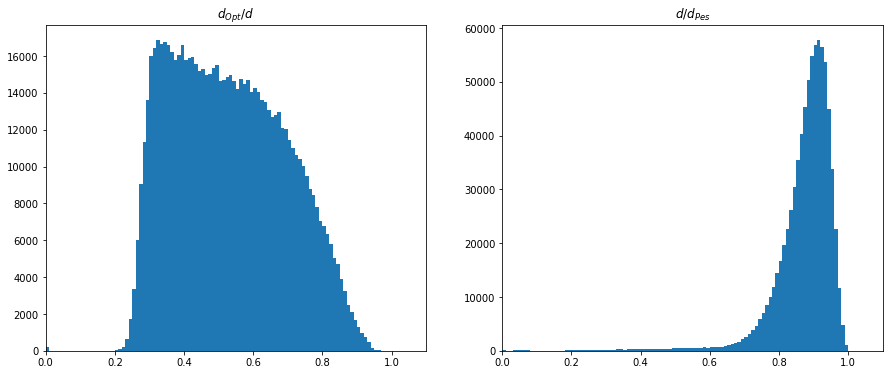

In [11]:
version = 's+op-v3maxrmsd7-lin15'
distance = np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-{version}.csv')
opt_s_distance = np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-s_Opt-v3maxrmsd7.csv')
pes_s_distance = np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-s_Pes-v3maxrmsd7.csv')
distance[distance==0] = np.nan
ratio_o = (opt_s_distance/distance).flatten()
ratio_p = (distance/pes_s_distance).flatten()
ratio_o = ratio_o[~np.isnan(ratio_o)]
ratio_p = ratio_p[~np.isnan(ratio_p)]
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.hist(ratio_o.flatten(), bins=np.arange(0,1.1,0.01))
plt.axis(xmin=0, xmax=1.1)
plt.title('$d_{Opt} / d$')
plt.subplot(1,2,2)
plt.title('$d / d_{Pes}$')
plt.hist(ratio_p.flatten(), bins=np.arange(0,1.1,0.01))
plt.axis(xmin=0, xmax=1.1)
None

334 548 256.8909604847431 256.8909378051758
334 817 212.34656843543053 212.3465576171875
548 334 256.8909604847431 256.8909378051758
673 833 109.70332464575768 109.70332336425781
817 334 212.34656843543053 212.3465576171875
833 673 109.70332464575768 109.70332336425781
(array([334, 334, 548, 673, 817, 833]), array([548, 817, 334, 833, 334, 673]))
length0: 6
total_rejectedness_l: 0.1465066339443211
total_rejectedness_s: 0.038360559347598466


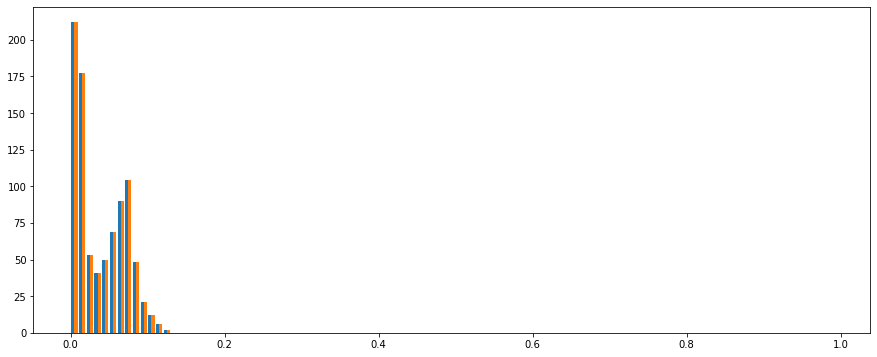

In [24]:
version = 's+op-v3maxrmsd7-lin15'
plt.figure(figsize=(15, 6))
rejectedness_by_length(ts.RESULTS / f'distance_{n}x{n}-{version}.csv', ts.RESULTS / f'length_{n}.csv', ts.RESULTS / f'distance_{n}x{n}-s_Opt-v3maxrmsd7.csv', ts.RESULTS / f'distance_{n}x{n}-s_Pes-v3maxrmsd7.csv')

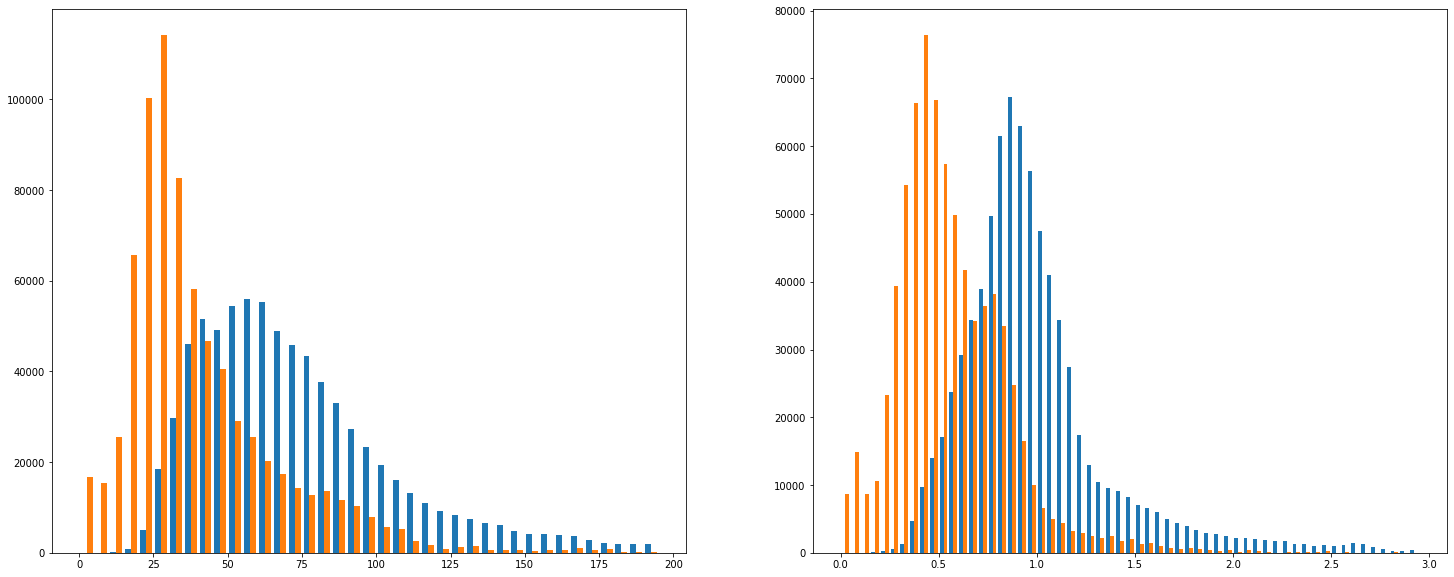

In [8]:
version = 'v3maxrmsd7'
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
distance_histogram(ts.RESULTS / f'distance_{n}x{n}-{version}.csv', families)
plt.subplot(1, 2, 2)
distance_histogram(ts.RESULTS / f'distance_{n}x{n}-{version}.csv', families, relative=True)

0.00 1a7uA00  38.97 5dnvA00  42.94 3pi6A01  51.07 3dkrA00  63.13 5du6A00  64.45 3hrhA00  65.05 1gqnA00  66.19 1gz6A01  67.57 3e4dA00  67.90 3n57A01  67.92 2i3zA01  68.11 2z4jA00  68.31 3ch6A00  68.40 3uwuA00  68.78 1yyeA00  68.80 4d42A00  68.82 5dx3A00  68.89 3qxjA00  68.95 3ovrA00  69.09 3gg7A00  69.29 1yqtA01  69.32 2aa2A00  69.61 2pblA01  69.64 5kyaA00  69.64 3lhyA00  69.69 5vb3A00  70.20 3ajxA00  70.38 3az3A00  70.45 3i62A01  70.63 2ov4A01  70.70 2x2gA00  70.73 3df9A00  70.86 4ymlA00  70.87 4eyqA01  70.93 2y85A00  70.96 1x7rA00  70.99 2w7hA02  71.01 5xfwA01  71.12 4gyuA00  71.29 4ibrA00  71.37 4zdlA02  71.43 2bifA01  71.63 3hzfA00  71.90 5zweA00  71.98 4i26A01  72.12 6ioyA01  72.16 4ddyA00  72.21 1tdgA00  72.25 2ng1A02  72.25 3aejA01  72.28 2qujA01  72.30 1g6kA00  72.31 4fm0A02  72.38 2yw3A00  72.40 4zl7A00  72.60 5aq8A02  72.66 4rx2A00  72.67 5imnA00  72.71 3zjiA00  72.78 3qnbA00  72.83 1j8mF02  72.84 1zc9A02  72.88 2ffiA00  73.08 5zcrA01  73.11 5omoA02  73.15 3dkpA00  73.21 3mwcA

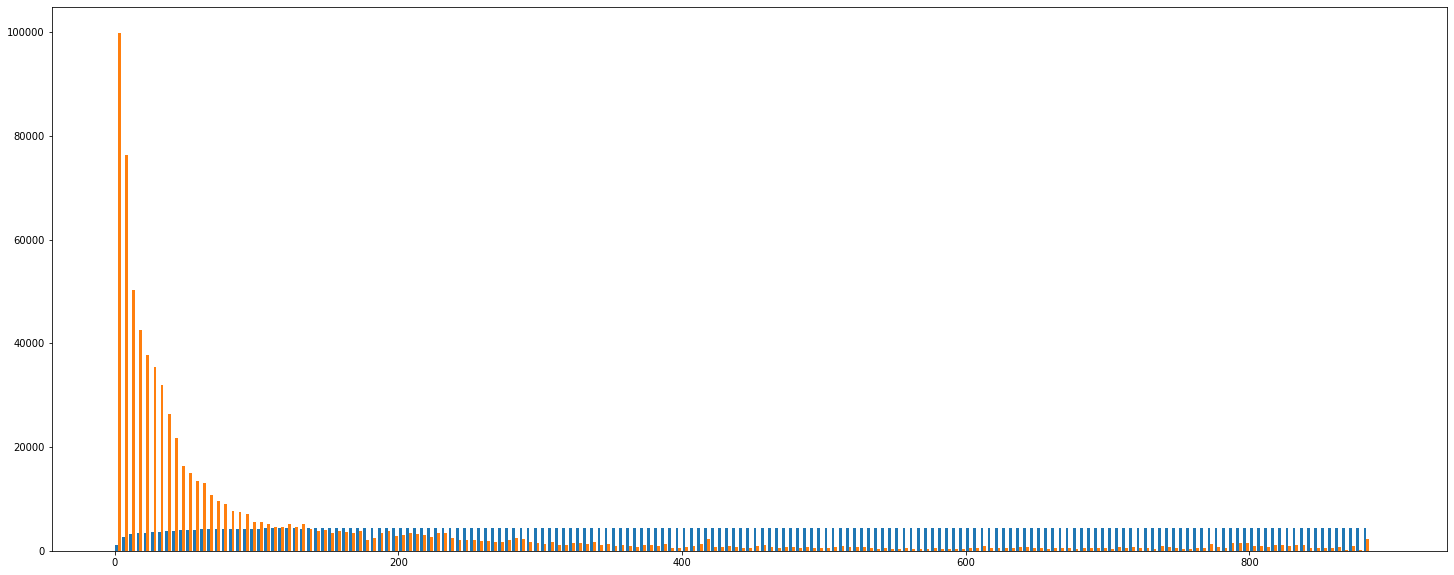

In [9]:
version = 'v3maxrmsd7'
plt.figure(figsize=(25, 10))
rank_histogram(ts.RESULTS / f'distance_{n}x{n}-{version}.csv', families)

In [6]:
versions = '''maxrmsd3 maxrmsd5 maxrmsd7 maxrmsd8 maxrmsd10 maxrmsd12 maxrmsd15 
v2-maxrmsd3 v2-maxrmsd5 v2-maxrmsd7 v2-maxrmsd10 v3maxrmsd3 v3maxrmsd5 v3maxrmsd7 v3maxrmsd10 
op-exp5 op-exp7 op-exp10 op-exp15 op-exp18 op-exp20 op-exp22 op-exp25 op-exp30 
op-lin5 op-lin7 op-lin10 op-lin12 op-lin15 op-lin17 op-lin20 
sop-maxrmsd7+lin15 sop-maxrmsd7+exp20 sop-maxrmsd7*lin15 sop-maxrmsd7*exp20 
s+op-v2maxrmsd7-lin15 s+op-v2maxrmsd7-exp20 s*op-v2maxrmsd7-lin15 s*op-v2maxrmsd7-exp20 
s+op-v3maxrmsd5-lin15 s+op-v3maxrmsd5-exp20 s+op-v3maxrmsd7-lin15 s+op-v3maxrmsd7-exp20 
s*op-v3maxrmsd7-lin15 s*op-v3maxrmsd7-exp20 s*op-v3maxrmsd7-lin20 s*op-v3maxrmsd7-exp25'''.split()
for version in versions:
    bH, bT, bA, bC, *_ = distance_badness(ts.RESULTS / f'distance_{n}x{n}-{version}.csv', domains, families)
    print(f'{version:20}', *('{:.4f}'.format(b) for b in (bH, bT, bA, bC)), sep='\t')
sum([count for fam, count in fam_counts.items() if count==1]), 3/885

maxrmsd3            	0.3322	0.3254	0.3153	0.2565
maxrmsd5            	0.1898	0.1785	0.1503	0.1096
maxrmsd7            	0.1672	0.1401	0.1119	0.0531
maxrmsd8            	0.1661	0.1379	0.1073	0.0452
maxrmsd10           	0.1718	0.1345	0.1073	0.0395
maxrmsd12           	0.1864	0.1492	0.1164	0.0362
maxrmsd15           	0.2215	0.1774	0.1367	0.0463
v2-maxrmsd3         	0.2588	0.2475	0.2294	0.1842
v2-maxrmsd5         	0.1661	0.1446	0.1220	0.0678
v2-maxrmsd7         	0.1684	0.1356	0.1073	0.0497
v2-maxrmsd10        	0.2023	0.1582	0.1198	0.0384
v3maxrmsd3          	0.1944	0.1819	0.1548	0.1085
v3maxrmsd5          	0.1616	0.1299	0.1006	0.0362
v3maxrmsd7          	0.1740	0.1379	0.1062	0.0339
v3maxrmsd10         	0.2203	0.1740	0.1311	0.0429
op-exp5             	0.1164	0.0904	0.0757	0.0644
op-exp7             	0.0927	0.0644	0.0486	0.0373
op-exp10            	0.0712	0.0452	0.0294	0.0192
op-exp15            	0.0667	0.0395	0.0249	0.0147
op-exp18            	0.0644	0.0384	0.0249	0.0124
op-exp20            

(3, 0.003389830508474576)

In [102]:
sw = 0.5
mixed_distance = (sw * np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-maxrmsd7.csv') + (1-sw) * np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-op-lin10.csv'))
bH, bT, bA, bC, *_ = distance_badness(mixed_distance, domains, families)
print(*('{:.4f}'.format(b) for b in (bH, bT, bA, bC)), sep='\t')

mixed_distance = (sw * np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-maxrmsd7.csv') + (1-sw) * np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-op-lin15.csv'))
bH, bT, bA, bC, *_ = distance_badness(mixed_distance, domains, families)
print(*('{:.4f}'.format(b) for b in (bH, bT, bA, bC)), sep='\t')

mixed_distance = (sw * np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-maxrmsd7.csv') + (1-sw) * np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-op-exp20.csv'))
bH, bT, bA, bC, *_ = distance_badness(mixed_distance, domains, families)
print(*('{:.4f}'.format(b) for b in (bH, bT, bA, bC)), sep='\t')

mixed_distance = (sw * np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-maxrmsd7.csv') + (1-sw) * np.loadtxt(ts.RESULTS / f'distance_{n}x{n}-op-exp22.csv'))
bH, bT, bA, bC, *_ = distance_badness(mixed_distance, domains, families)
print(*('{:.4f}'.format(b) for b in (bH, bT, bA, bC)), sep='\t')

0.0723	0.0475	0.0350	0.0181
0.0701	0.0395	0.0271	0.0147
0.0746	0.0463	0.0282	0.0068
0.0780	0.0486	0.0294	0.0068


In [62]:
# distance_badness(ts.RESULTS / f'distance_{n}x{n}-maxrmsd7.csv', domains, families, verbose=True)
# print('-'*50)
distance_badness(mixed_distance, domains, families, verbose=True)
None

2m8eA00	2r0qC02	1.10.10.10   (15)	1.10.10.60   (7)
2o3fA00	1jtxA01	1.10.10.10   (15)	1.10.10.60   (7)
4q5sF02	1jtxA01	1.10.10.10   (15)	1.10.10.60   (7)
1d0kA02	1xydA00	1.10.530.10   (11)	1.10.238.10   (8)
3qjkA00	4q5sF02	1.10.238.10   (8)	1.10.10.10   (15)
1jtxA01	4q5sF02	1.10.10.60   (7)	1.10.10.10   (15)
1tf0A01	1zqzA01	1.10.246.10   (1)	1.10.150.20   (12)
3proA01	1bibA03	2.40.10.10   (26)	2.30.30.100   (2)
5t6fA01	3uytA01	2.40.10.10   (26)	3.30.200.20   (49)
1pfsA00	1cskA00	2.40.50.140   (10)	2.30.30.40   (5)
1vciA03	1ckaA00	2.40.50.140   (10)	2.30.30.40   (5)
5ffhA00	5gioE01	2.40.128.20   (7)	3.30.200.20   (49)
1q43A02	1jtxA01	2.60.120.10   (7)	1.10.10.60   (7)
1bhgA01	3zoaA03	2.60.120.260   (6)	2.60.40.1180   (8)
6aj0B00	2opkA01	2.60.120.20   (3)	2.60.120.10   (7)
1bibA03	2j6oA00	2.30.30.100   (2)	2.30.30.40   (5)
5gioE01	1nziA02	3.30.200.20   (49)	2.10.25.10   (5)
3iimA00	1ffsA00	3.40.50.300   (38)	3.40.50.2300   (9)
3o8cA03	4hktA01	3.40.50.300   (38)	3.40.50.720   (36)
5j40A03	

In [64]:
distance = mixed_distance
i_5gio = np.where(domains=='5gioE01')[0][0]
print(i_5gio)
hits = [f'{d:.3f}\t{dom}\t{fam}' for d, dom, fam in sorted(zip(distance[i_5gio], domains, families))]
print(*hits[:20], sep='\n')
np.argmin(distance[i_5gio])
# np.min(distance[0])
nans = np.where(np.isnan(distance[0]))
nans, domains[nans], families[nans]

424
0.000	5gioE01	3.30.200.20
22.064	1nziA02	2.10.25.10
24.788	2j6oA00	2.30.30.40
25.092	1ckaA00	2.30.30.40
25.325	1cskA00	2.30.30.40
26.092	1iqgL00	2.10.25.10
26.290	1bibA03	2.30.30.100
26.527	2phbB00	2.10.25.10
26.659	2r3gA01	3.30.200.20
26.828	2bq6A00	2.10.25.10
26.984	2krnA00	2.30.30.40
27.135	4q5eA01	3.30.200.20
27.431	5y20A00	3.30.40.10
27.944	4fktA01	3.30.200.20
28.287	3uytA01	3.30.200.20
29.193	1y8yA01	3.30.200.20
29.243	5hgiA01	3.30.200.20
29.391	1vciA03	2.40.50.140
29.562	6hm6A01	3.30.200.20
29.632	2evaA01	3.30.200.20


((array([], dtype=int64),), array([], dtype='<U7'), array([], dtype='<U13'))

In [67]:
rotations = np.load(ts.RESULTS / 'rotations_20x20-op-lin10.npy')
translations = np.load(ts.RESULTS / 'translations_20x20-op-lin10.npy')
rotations.shape, translations.shape, rotations.max(), rotations.min(), translations.max(), translations.min()

((20, 20, 3, 3),
 (20, 20, 1, 3),
 1.0000000000000004,
 -0.9999609197964008,
 21.194041055790912,
 -23.839824719511864)

In [14]:
def seconds(s): return timedelta(seconds=s)

In [18]:
print(seconds(25) / 200**2 * 6565**2)
print(seconds(363) / 1000**2 * 6565**2)

7:28:57.015625
4:20:45.018675


In [59]:
print(seconds(25) /100**2 *885**2)
1378/7280*100, 3170/7280*100
885-388
print(timedelta(minutes=12) /885**2 *6565**2)
# distance matrix 200x200 (shapedist-maxrmsd7): 51 s
# distance matrix 200x200 (shapedist-maxrmsd7): 47 s (precomputed shapes)
# distance matrix 200x200 (shapedist-maxrmsd7): 42 s (precomputed shapes, omitting center point of the shape)
# distance matrix 200x200 (op-r10): 12:25
# distance matrix 885x885 (op-r10): 2:56:00

0:32:38.062500
11:00:08.187775


In [84]:
nd = 885
n_calc = n * (n+1) // 2
print('shapedist', timedelta(minutes=12) / n_calc *6565)
print('opdist', timedelta(hours=2, minutes=56) / n_calc *6565)

shapedist 0:00:12.053340
opdist 0:02:56.828275


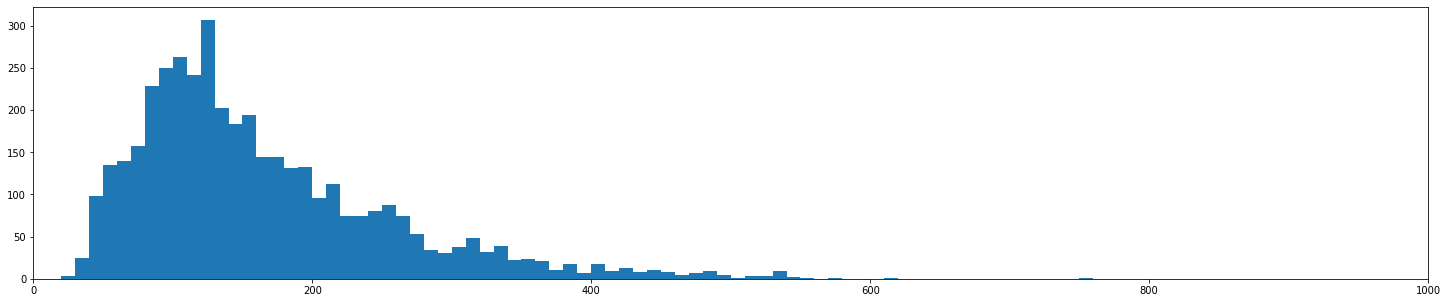

In [24]:
lengths = np.loadtxt('/home/adam/Workspace/Python/OverProt/data-ssd/tree/sample4076/results/length_4076.csv')
plt.figure(figsize=(25, 5))
plt.hist(lengths, bins=range(0,1000,10))
plt.axis(xmin=0, xmax=1000) and None

In [4]:
print(timedelta(seconds=56) / 1_379_749)
print(timedelta(hours=1) / 88500)
88500**2 * 8e-9 * 0.1
n = 4076
print(timedelta(seconds=0.028) * n*(n-1)//2 * 0.041)
print(timedelta(seconds=0.028) * n)
print(timedelta(seconds=0.01) * 32**2/2 * (400_000/32))
print(timedelta(hours=2.5) / (4076*np.log(4076)) * (4e5*np.log(4e5)))
print(timedelta(hours=2.5) / 3 / 4076 * 4e5)
print(timedelta(hours=54, minutes=15) /4076 *4e5 *0.004)
print(timedelta(hours=3, minutes=16) / (4076*4075//2))
print(timedelta(seconds=0.028) *4076 *0.36)
82/4076

0:00:00.000041
0:00:00.040678
2:38:53.967800
0:01:54.128000
17:46:40
15 days, 20:41:45.988707
3 days, 9:46:46.400000
21:17:43.395200
0:00:00.001416
0:00:41.086080


0.020117762512266928

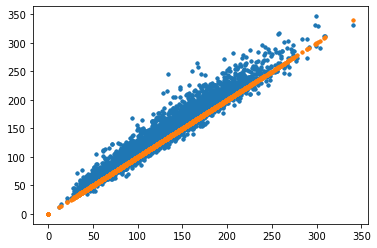

In [12]:
RESULTS = Path('/home/adam/Workspace/Python/OverProt/data-ssd/tree/sample4076/results')
n = 100
d_op = np.loadtxt(RESULTS/f'distance_{n}x{n}-op-lin15.csv')
d_opi0 = np.loadtxt(RESULTS/f'distance_{n}x{n}-opi0-lin15.csv')
d_opi1 = np.loadtxt(RESULTS/f'distance_{n}x{n}-opi1-lin15.csv')
d_opi3 = np.loadtxt(RESULTS/f'distance_{n}x{n}-opi3-lin15.csv')
d_opi10 = np.loadtxt(RESULTS/f'distance_{n}x{n}-opi10-lin15.csv')
plt.plot(d_op.flatten(), d_opi1.flatten(), '.')
# plt.plot(d_op.flatten(), d_opi3.flatten(), '.')
# plt.plot(d_op.flatten(), d_opi10.flatten(), '.')
plt.plot(d_op.flatten(), d_opi0.flatten(), '.')